<a href="https://colab.research.google.com/github/Amogh24/Fake_news/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import sys
import csv

csv.field_size_limit(sys.maxsize)
csv.field_size_limit(100000000)
csv.field_size_limit(sys.maxsize)

100000000

In [ ]:
import pandas as pd
raw_news=pd.read_csv('/content/gdrive/MyDrive/fake-news/train.csv',engine='python')




In [ ]:
true_raw_news=raw_news[raw_news['label']==0]

In [ ]:
true_raw_news.head()

,id,title,author,text,label
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [ ]:
fake_raw_news=raw_news[raw_news['label']==1]
fake_raw_news.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


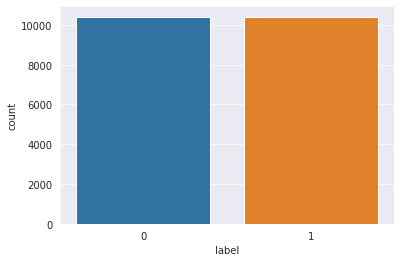

In [ ]:
target = raw_news['label']
sns.set_style('darkgrid')
sns.countplot(target)

In [ ]:
import torch

In [ ]:
import torchtext

In [ ]:

import string
import nltk
import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

punct = set(string.punctuation)
t={'\n'}
stopwords = set(stopwords.words('english'))
#s=stopwords.union(punct)
s=punct.union(t)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function

    return [tok.text for tok in spacy_en.tokenizer(text)]

#TEXT = torchtext.data.Field(preprocessing=getClearReview,sequential=True, lower=True,tokenize=tokenizer)
TEXT = torchtext.legacy.data.Field(sequential=True, lower=True,tokenize=tokenizer,use_vocab=True,stop_words=s,fix_length=700)
#TEXT = torchtext.data.Field(sequential=True, lower=True,use_vocab=True,fix_length=700)
LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=True)

In [ ]:
fields = [(None, None),(None, None),(None, None), ('text',TEXT),('label', LABEL)]

In [ ]:
training_data=torchtext.legacy.data.TabularDataset(path = '/content/gdrive/MyDrive/fake-news/train.csv',format = 'csv',fields = fields,skip_header = True)

In [ ]:
#print(vars(training_data.examples[0]))
TEXT.build_vocab(training_data)
LABEL.build_vocab(training_data)


In [ ]:
from torchtext import vocab
glove=vocab.Vectors("glove.6B.50d.txt","/content/gdrive/MyDrive/")
TEXT.build_vocab(training_data,vectors='glove.6B.100d',unk_init=torch.Tensor.zero_,max_size=50000) 
LABEL.build_vocab(training_data)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                           
100%|█████████▉| 398146/400000 [00:14<00:00, 26692.46it/s]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Cuda Status on system is True


In [ ]:

VOCAB_SIZE = 194298
EMBED_DIM = 100

embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)

In [ ]:
embedding.weight.size()

torch.Size([194298, 100])

In [ ]:
from torch.utils.data import Dataset, DataLoader


In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 50002
Unique tokens in LABEL vocabulary: 3


In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(
    
                              # Datasets for iterator to draw data from
                              (training_data),

                              # Tuple of train and validation batch sizes.
                              batch_size=64,

                              # Device to load batches on.
                              device=device, 

                              # Function to use for sorting examples.
                              sort_key=lambda x: len(x.text),


                              # Repeat the iterator for multiple epochs.
                              #repeat=True, 

                              # Sort all examples in data using `sort_key`.
                              sort=True, 

                              # Shuffle data on each epoch run.
                              shuffle=True,

                              # Use `sort_key` to sort examples in each batch.
                              
                              )

# Print number of batches in each split.
print('Created `train_iter` with %d batches!'%len(train_iter))

Created `train_iter` with 325 batches!


In [ ]:

print(type(train_iter))


<class 'torchtext.legacy.data.iterator.BucketIterator'>


In [ ]:

train_dataloader = (train_iter)





In [ ]:
iterator = train_dataloader
print(len(list(iterator)))
print(type(list(iterator)))
print(iterator)

100%|█████████▉| 398146/400000 [00:30<00:00, 26692.46it/s]

325
<class 'list'>


In [ ]:
model = SWEMWithEmbeddings(
    vocab_size = 194298,
    embedding_size = 100, 
    hidden_dim1 = 80,
    dim2 = 40, 
    num_outputs = 1,
)
weights=list(model.parameters())

# Binary cross-entropy (BCE) Loss and Adam Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for epoch in range(100):
    correct = 0
    num_examples = 0
    
    #for (inputs,labels) in enumerate(train_dataloader):
    for batch in train_dataloader:
        # Zero out the gradients
        inputs=batch.text
        labels=batch.label
        
        optimizer.zero_grad()
        
        # Forward pass
        y = model(inputs)
        yr = torch.round(y)
       
        
        labels=labels.unsqueeze(1)
        labels=labels.float()
        labels=torch.sub(labels,1,alpha=1)
        
        loss = criterion(yr, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        
        
        correct += torch.sum((yr == labels).float())
        num_examples += len(inputs)
    
    # Print training progress
    if epoch % 1 == 0:
        acc = correct/num_examples
        print(weights[0].grad)
        print("Epoch: {0} \t Train Loss: {1} \t Train Acc: {2}".format(epoch, loss, acc))

## Testing
# correct = 0
# num_test = 0

# with torch.no_grad():
#     # Iterate through test set minibatchs 
#     for inputs, labels in test_loader:
#         # Forward pass
#         y = model(inputs)
        
#         predictions = torch.round(torch.sigmoid(y))
#         correct += torch.sum((predictions == labels).float())
#         num_test += len(inputs)
    
# print('Test accuracy: {}'.format(correct/num_test))

NameError: ignored

In [ ]:
from torch.nn.utils.rnn 

ret = [glove.get_vecs_by_tokens(i.text)  for i in training_data[0:5]]
   
rets=pad_sequence(ret)
 

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_size, hidden_dim1,dim2, num_outputs):
        super(Linear,self).__init__()
       
        self.fc1 = nn.Linear(input_size, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, dim2)
        self.fc3 = nn.Linear(dim2,num_outputs)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, text):
        #text=self.embedding(text)
        #text=text.view(text.size()[0],-1)
        text=text.float()

        h1 = self.fc1(text)
        h1 = torch.sigmoid(h1)
        h1= self.dropout(h1)
        h2 = self.fc2(h1)
        h2 = F.relu(h2)
        h3 = self.fc3(h2)
        
        
        return (h3)

In [ ]:
model = Linear(
    input_size=700,
    hidden_dim1 = 300,
    dim2=100,
    num_outputs = 1,
)

weights=list(model.parameters())
for w in weights:
  print(w.grad)

In [ ]:

# Binary cross-entropy (BCE) Loss and Adam Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Iterate through train set minibatchs 
for epoch in range(500):
    correct = 0
    num_examples = 0
    
    #for (inputs,labels) in enumerate(train_dataloader):
    for batch in train_dataloader:
        # Zero out the gradients
        #inputs=batch.text
        
        text=batch.text
               
        text=text.view(64,700)
        labels=batch.label
        #inputs=inputs.view(64,700)
        #inputs=inputs.float()
        
        optimizer.zero_grad()
        
        # Forward pass
        #y = model(inputs)
        y=model(text)
        yr = torch.squeeze(torch.round(torch.sigmoid(y)))
        
        yr=yr.float()
        
        labels=torch.sub(labels,1,alpha=1)
        labels=labels.float()
        
        
        loss = criterion(yr, labels)
        
        
        # Backward pass
        loss.backward()
        
        optimizer.step()
        
        
        
        correct += torch.sum((yr == labels).float())
        num_examples += len(text)
    
    # Print training progress
    if epoch % 5 == 0:
          
        acc = (correct/num_examples)*100
        print(weights[0].grad)
        
        print("Epoch: {0} \t Train Loss: {1} \t Train Acc: {2}".format(epoch, loss, acc))
        #print("Epoch: {0} \t Train Loss: {1} \t Correct: {2}".format(epoch, loss, correct))

In [ ]:
for batch in train_dataloader:
  print(glove.get_vecs_by_tokens(batch.text))

In [ ]:
ret = [glove.get_vecs_by_tokens(i.text)  for i in training_data[0:5]]
print(ret)

In [ ]:
sentences=['hello','hi']
print(glove.get_vecs_by_tokens(sentences[1]))


In [ ]:
class RNN(nn.Module):
   def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
     super().__init__()
        
     self.embedding = nn.Embedding(input_dim, embedding_dim)
     self.rnn = nn.RNN(embedding_dim, hidden_dim)
     self.fc = nn.Linear(hidden_dim, output_dim)

   def forward(self, x):

        #x = [sent len, batch size]
        
       embedded = self.embedding(x)
        
        #embedded = [sent len, batch size, emb dim]
        
       output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
       assert torch.equal(output[-1,:,:], hidden.squeeze(0))
       
       out = self.fc(hidden)
       return out


In [ ]:
class Linear_rnn(nn.Module):
   def __init__(self, input_dim, embedding_dim, hidden_dim, hidden_dim2,dim2, output_dim):
     super().__init__()
        
     self.embedding = nn.Embedding(input_dim, embedding_dim)
     self.rnn = nn.LSTM(embedding_dim, hidden_dim)

     self.fc1 = nn.Linear(hidden_dim, hidden_dim2)
     self.rnn2= nn.LSTM(hidden_dim2,dim2)
     self.fc2 = nn.Linear(dim2,output_dim)
     

   def forward(self, x):

        #x = [sent len, batch size]
        # print(x.shape)
       embedded = self.embedding(x)
       
        #embedded = [sent len, batch size, emb dim]
        
       output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
      #  assert torch.equal(output[-1,:,:], hidden.squeeze(0))
       output=output.reshape(-1,hidden_dim)
       out = self.fc1(hidden)
       a,b=self.rnn2(out)
       a=a.reshape(-1,dim2)
      #  assert torch.equal(a[-1,:,:], b.squeeze(0))
       res = self.fc2(b)
       return res

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 374
OUTPUT_DIM = 2

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

NameError: ignored

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 374
Dim2=80
OUTPUT_DIM = 2
HIDDEN_DIM2=200

model2 = Linear_rnn(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM,HIDDEN_DIM2,Dim2, OUTPUT_DIM)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)


torch.Size([50002, 100])


In [ ]:
model2.embedding.weight.data = pretrained_embeddings.cuda()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
model2 = model2.to(device)
class_weights = torch.tensor([1.0, 15.0]).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

In [ ]:
model.embedding.weight.data = pretrained_embeddings.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
class_weights = torch.tensor([1.0, 15.0]).cuda()

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
    correct = (ind == y).float()
    acc = correct.sum()/float(len(correct))
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        labels=batch.label       
        predictions = model(batch.text).squeeze(0)
        labels=torch.sub(labels,1,alpha=1)
#         print(predictions.shape, batch.Label.shape, model(batch.Text).shape)
        loss = criterion(predictions, labels)
#         print(loss.shape)
        acc = binary_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS=150
for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    print(train_acc)

0.5490865384615384
0.5444711538461539
0.5872115384615385
0.5549038461538461
0.5509615384615385
0.5545673076923077
0.5525
0.5548557692307692
0.5550480769230769
0.5655288461538461
0.5571153846153846
0.5591826923076924
0.5565384615384615
0.5567307692307693
0.5595192307692308
0.5465384615384615
0.5534134615384615
0.5523557692307692
0.551875
0.5514903846153846
0.5507211538461538
0.5494230769230769
0.5492788461538461
0.5505288461538461
0.5494230769230769
0.556826923076923
0.5611538461538461
0.5641826923076924
0.5703846153846154
0.5779807692307692
0.5867788461538461
0.5992788461538462
0.5904326923076924
0.6048076923076923
0.6076442307692308
0.6280769230769231
0.6303846153846154
0.630625
0.6142788461538462
0.6253365384615385
0.6175480769230769
0.6115384615384616
0.6105288461538462
0.6113942307692307
0.6211057692307692
0.5670673076923077
0.5535096153846154
0.5642307692307692
0.5691346153846154
0.5773076923076923
0.5776442307692308
0.5759134615384616
0.5673557692307692
0.5687980769230769
0.56533

In [ ]:
N_EPOCHS=150
for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model2, train_dataloader, optimizer, criterion)
    print(train_acc)

NameError: ignored